In [145]:
import time
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM
#from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datalab.bigquery as bq
import pandas as pd
import numpy as np
import collections
import math
import shutil


In [104]:
def convertSPPMonthlyDA(fname):
    #fname = "data/DA-LMP-MONTHLY-SL-201608.csv"
    col_names = ['Date', 'Settlement Location Name', 'PNODE Name', 'Price Type', 'HE01','HE02','HE03','HE04','HE05','HE06','HE07','HE08','HE09','HE10','HE11','HE12','HE13','HE14','HE15','HE16','HE17','HE18','HE19','HE20','HE21','HE22','HE23','HE24']
    da_price = pd.read_csv(fname, header=0, names=col_names)
    df = pd.DataFrame(da_price)
    date_split = df['Date'].str.split('/').str
    market_days = collections.OrderedDict()

    for index, row in df.iterrows():
        nodes = collections.OrderedDict()
        hours = collections.OrderedDict()   

        if not market_days.has_key(row['Date'].replace("/","")):
            market_days[row['Date'].replace("/","")] = {}
        nodes = market_days.get(row['Date'].replace("/",""))

        if not nodes.has_key(row['Settlement Location Name']):
            nodes[row['Settlement Location Name']] = {}
        hours = nodes.get(row['Settlement Location Name'])

        for index in range(4,len(row)):
            index = index - 4
            #LMP, MCC, MLC
            prices = [0,0,0]
            if index<9:
                hourstring = 'HE0'+str(index+1)
            else:
                hourstring = 'HE'+str(index+1)

            if not hours.has_key(str(hourstring)):
                hours[hourstring] = prices
            prices = market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring]

            if row['Price Type'] == 'LMP':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][0] = row[hourstring]
            elif row['Price Type'] == 'MCC':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][1] = row[hourstring]
            elif row['Price Type'] == 'MLC':
                market_days[row['Date'].replace("/","")][row['Settlement Location Name']][hourstring][2] = row[hourstring]
    with open('sppdamarket.csv', 'a') as out:
        #out.write('day,node,hour,lmp,mcc,mlc\n') #header
        for day in market_days.keys():
            for gen in market_days[day].keys():
                for hour in market_days[day][gen].keys():
                    if not math.isnan(market_days[day][gen][hour][0]):
                        out.write(day + "," + gen + "," + hour + "," + 
                                  str(market_days[day][gen][hour][0]) + "," + 
                                  str(market_days[day][gen][hour][1]) + "," + 
                                  str(market_days[day][gen][hour][2]) + "\n")

    with open('sppdamec.csv', 'a') as out:
        #out.write('day,hour,mec\n') #header
        for day in market_days.keys():
            for hour in next(market_days[day].itervalues()).keys():
                if not math.isnan(next(market_days[day].itervalues())[hour][0]):
                    out.write(day + "," + hour + "," + 
                        str(next(market_days[day].itervalues())[hour][0] - next(market_days[day].itervalues())[hour][1] - next(market_days[day].itervalues())[hour][2]) + "\n")


In [106]:
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201608.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201609.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201610.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201611.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201612.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201701.csv")
convertSPPMonthlyDA("data/DA-LMP-MONTHLY-SL-201702.csv")

In [129]:
fname = "sppdamec.csv"
coln = ['Date','Hour','mec']
mec = pd.read_csv(fname, names=coln)
mdf = pd.DataFrame(mec)
mdf['Hour'] = mdf['Hour'].str.lstrip('HE')
mdf = mdf.sort_values(['Date', 'Hour'], ascending=[1, 1])
print(mdf.head())

      Date Hour      mec
0  8012016   01  28.9543
2  8012016   02  28.1353
1  8012016   03  23.0198
4  8012016   04  20.2738
3  8012016   05  19.6931


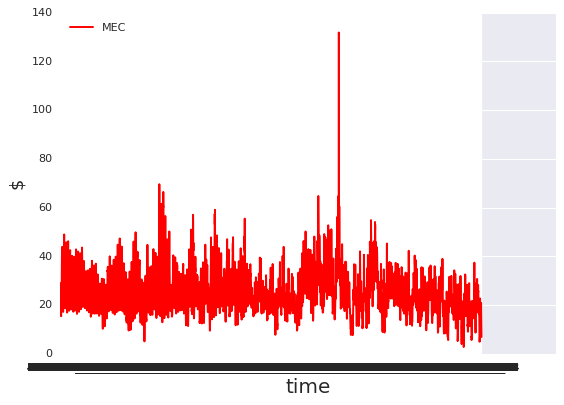

In [153]:
xl, yl = mdf.shape
x = range(xl)
fig, ax = plt.subplots()
ax.plot(x,mdf['mec'],color='red', label='MEC')
#plt.plot(y_test2,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.xlabel('time', fontsize=18)
plt.ylabel('$', fontsize=16)
plt.xticks(x,mdf['Date'].astype(str)+"_"+mdf['Hour'].astype(str))
#loc = ticker.MultipleLocator(base=1000.0) 
#ax.xaxis.set_major_locator(loc)
plt.show()

In [5]:
%projects set drwgry-proj

In [8]:
%bigquery schema --table "sppda_2016_8.t1"

In [10]:
%sql
SELECT Date AS daynumber FROM [sppda_2016_8.t1] LIMIT 10

daynumber
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
